In [3]:
#!/usr/bin/env python

import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from isoweek import Week
from cmdstanpy import CmdStanModel
from cmdstanpy import from_csv
import glob

In [4]:
# Parse ISO week format (e.g. "2020-W12") into a date (Monday of that ISO week)
def iso_week_to_date(iso_str):
    """
    Convert 'YYYY-Www' string into date.
    Example: "2020-W12" -> Monday of the 12th ISO week of 2020.
    """
    match = re.match(r"(\d{4})-W(\d{1,2})", iso_str)
    if not match:
        return None
    year, week = match.groups()
    year, week = int(year), int(week)
    return Week(year, week).monday()

In [5]:
# Read the 2010-2025 DK data
df = pd.read_csv("data/DK_2010_2025_posfrac.csv", dtype=str)
df["value"] = pd.to_numeric(df["PosFrac"])

# Create a 'date' column from 'year_Week'
df["date"] = df["year_Week"].apply(iso_week_to_date)
df['date'] = pd.to_datetime(df["date"])

print(df['date'])

0     2010-01-04
1     2010-01-11
2     2010-01-18
3     2010-01-25
4     2010-02-01
         ...    
793   2025-02-24
794   2025-03-03
795   2025-03-10
796   2025-03-17
797   2025-03-24
Name: date, Length: 798, dtype: datetime64[ns]


In [6]:
len(df['date'])

798

In [7]:
# Load in stan data:
csv_files = glob.glob('stan_output/sinusoid_2025/*20250404104108*.csv')

print(csv_files)

fit = from_csv(csv_files)

['stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_3.csv', 'stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_2.csv', 'stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_4.csv', 'stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_1.csv']


In [8]:
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



In [9]:
print("Parameter means:")
for var in ['S0', 'logx_I0', 'beta0', 'dbeta', 'betaphase', 'sigma_obs', 'rho', 'delta']:
#for var in ['S0', 'I0', 'beta0', 'dbeta', 'betaphase', 'sigma_obs', 'rho', 'tau']:
    print(f"{var}: {fit.stan_variable(var).mean()}")

Parameter means:
S0: 0.5689698045833333
logx_I0: -2.590903866666667
beta0: 0.7167610620833333
dbeta: 0.1855407425
betaphase: 3.5961723291666665
sigma_obs: 0.016248512791666666
rho: 0.019226591791666667
delta: 0.001713115354166667


In [10]:
# Extract confidence intervals using arviz

import arviz as az

idata = az.from_cmdstanpy(fit)
for var in ['S0', 'logx_I0', 'beta0', 'dbeta', 'betaphase', 'sigma_obs', 'rho', 'delta']:
    hpd = az.hdi(idata, var_names=[var], hdi_prob=0.95)

    print(f"{var}: {fit.stan_variable(var).mean()}" + "\t\t" + f"[{np.float64(hpd[var][0])} ; {np.float64(hpd[var][1])}]")
    if var=="delta":
        print(f"1/{var}: {(1/52)*1/fit.stan_variable(var).mean()} years" + "\t\t" + f"[{(1/52)*1/np.float64(hpd[var][1])} ; {(1/52)*1/np.float64(hpd[var][0])}]")

S0: 0.5689698045833333		[0.511473 ; 0.59999]
logx_I0: -2.590903866666667		[-2.62742 ; -2.55825]
beta0: 0.7167610620833333		[0.677473 ; 0.792592]
dbeta: 0.1855407425		[0.173638 ; 0.196629]
betaphase: 3.5961723291666665		[3.54618 ; 3.6499]
sigma_obs: 0.016248512791666666		[0.0153665 ; 0.0170743]
rho: 0.019226591791666667		[0.0171277 ; 0.0208457]
delta: 0.001713115354166667		[0.00133148 ; 0.00196575]
1/delta: 11.225612556676841 years		[9.782917070211996 ; 14.443152905615731]


I0 posterior mean +- sd: 0.001459 +- 0.000069


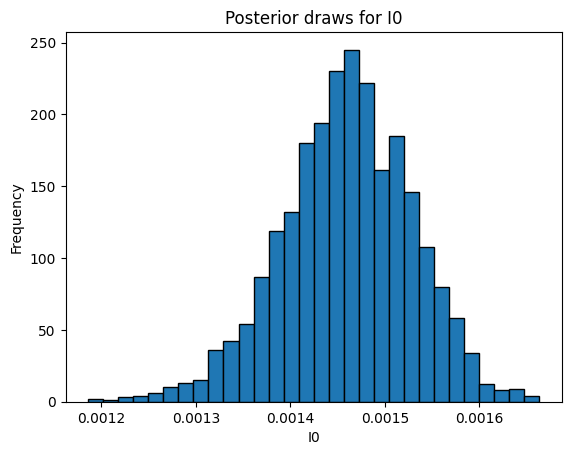

In [22]:
# Visualize draws for variable:
#var = 'sigma_obs'
#var = 'rho'
#var = 'beta0'
#var = 'betaphase'
#var = 'dbeta'
#var = 'delta'
var = 'I0'
#var = 'S0'
#var = 'x_I0'
#var = 'logx_I0'

v_samples = fit.stan_variable(var)

# Mean and standard deviation:
mean_v = v_samples.mean()
sd_v = v_samples.std()

print(f"{var} posterior mean +- sd: {mean_v:.6f} +- {sd_v:.6f}")
if var=='delta':
    print(f"1/(mean({var})) = {1/mean_v:.3f} weeks = {(1/52)*1/mean_v:.3f} years")
    print(f"+ standard deviation: 1/(mean({var})) = {1/(mean_v+sd_v):.3f} weeks = {(1/52)*1/(mean_v+sd_v):.3f} years")
    print(f"- standard deviation: 1/(mean({var})) = {1/(mean_v-sd_v):.3f} weeks = {(1/52)*1/(mean_v-sd_v):.3f} years")

plt.hist(v_samples, bins=30, edgecolor='k')
plt.title("Posterior draws for " + var)
plt.xlabel(var)
plt.ylabel("Frequency")
plt.show()


1317


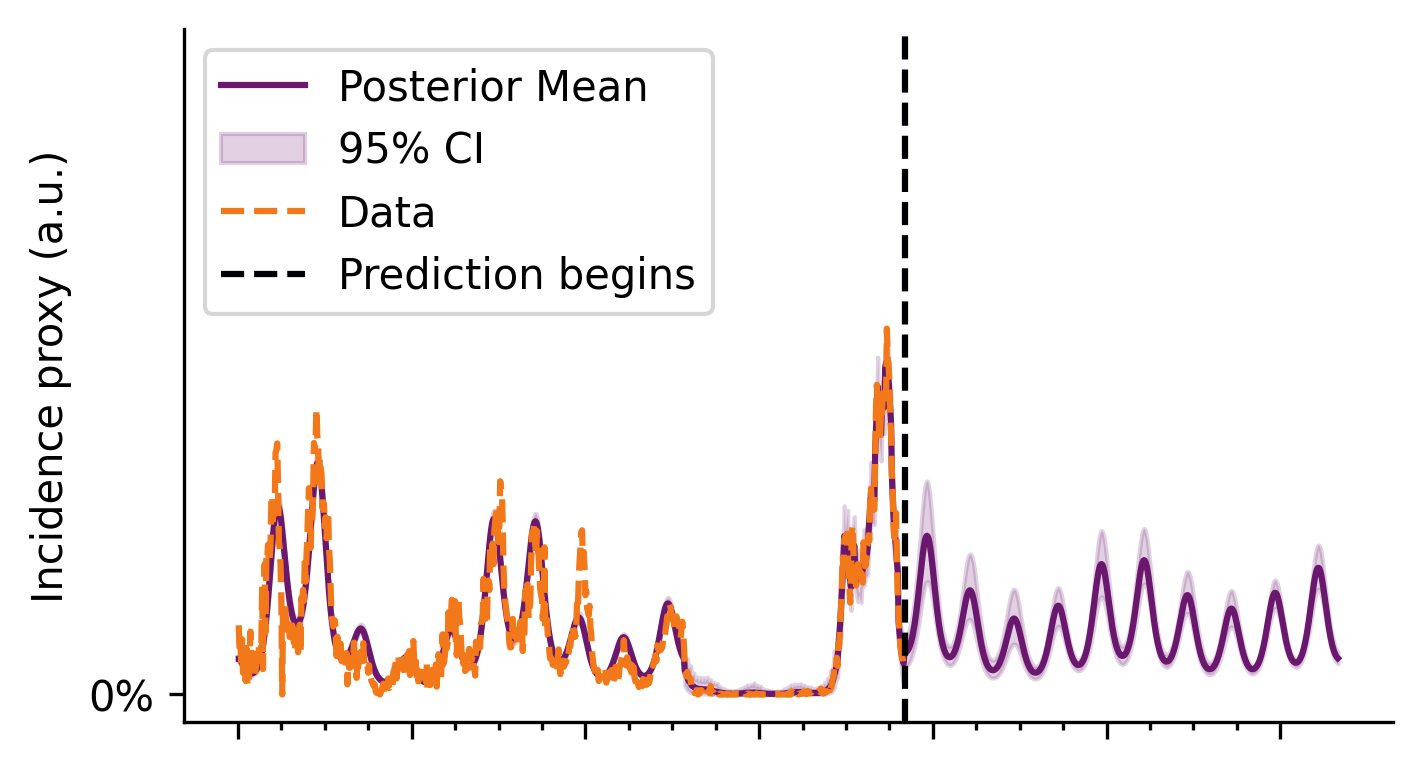

In [23]:
var = "Ifit"

v_draws = fit.stan_variable(var)
print(v_draws.shape[1])

plt.figure(figsize=(5.2, 3), dpi=300)

############

# S_draws.shape = (num_draws, N + Npred)
mean_v = np.mean(v_draws, axis=0)  # average over draws
lower_v = np.percentile(v_draws, 2.5, axis=0)  # 2.5% quantile
upper_v = np.percentile(v_draws, 97.5, axis=0) # 97.5% quantile

time_fit = np.arange(1, v_draws.shape[1] + 1)/52 + 2010
time_data = np.arange(1, len(df['value']) + 1)/52 + 2010

plt.plot(time_fit, mean_v, label='Posterior Mean', color=plt.cm.inferno(0.3))


plt.fill_between(time_fit, lower_v, upper_v, color=plt.cm.inferno(0.3), alpha=0.2, label='95% CI')

plt.plot(time_data, df['value'], "--", label="Data", color=plt.cm.inferno(0.7))

prediction_start_date = time_data[-1]+1/52
color = plt.cm.inferno(0.0)
plt.axvline(prediction_start_date, ls="--", color=color, label="Prediction begins")

plt.xticks(np.arange(2010,2035))
xticklabels = []
ax=plt.gca()
n=4
for i, tick in enumerate(ax.xaxis.get_major_ticks()):
    if i % n == 0:
        tick.tick1line.set_markersize(4)  # tick length
        tick.tick2line.set_markersize(4)
        #xticklabels.append(i+2010)
        xticklabels.append('')
    else:
        tick.tick1line.set_markersize(2)  # tick length
        tick.tick2line.set_markersize(2)
        xticklabels.append('')

plt.xticks(np.arange(2010,2035), labels=xticklabels)
plt.yticks([0], labels=['0%'])

plt.ylabel("Incidence proxy (a.u.)")
plt.legend(loc="upper left")

plt.ylim([-0.021, 0.5])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


2010-01-04 00:00:00
[Timestamp('2010-01-05 00:00:00'), Timestamp('2012-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'), Timestamp('2016-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'), Timestamp('2020-01-01 00:00:00'), Timestamp('2022-01-01 00:00:00'), Timestamp('2024-01-01 00:00:00'), Timestamp('2026-01-01 00:00:00'), Timestamp('2028-01-01 00:00:00'), Timestamp('2030-01-01 00:00:00'), Timestamp('2032-01-01 00:00:00'), Timestamp('2034-01-01 00:00:00'), Timestamp('2025-01-01 00:00:00')]


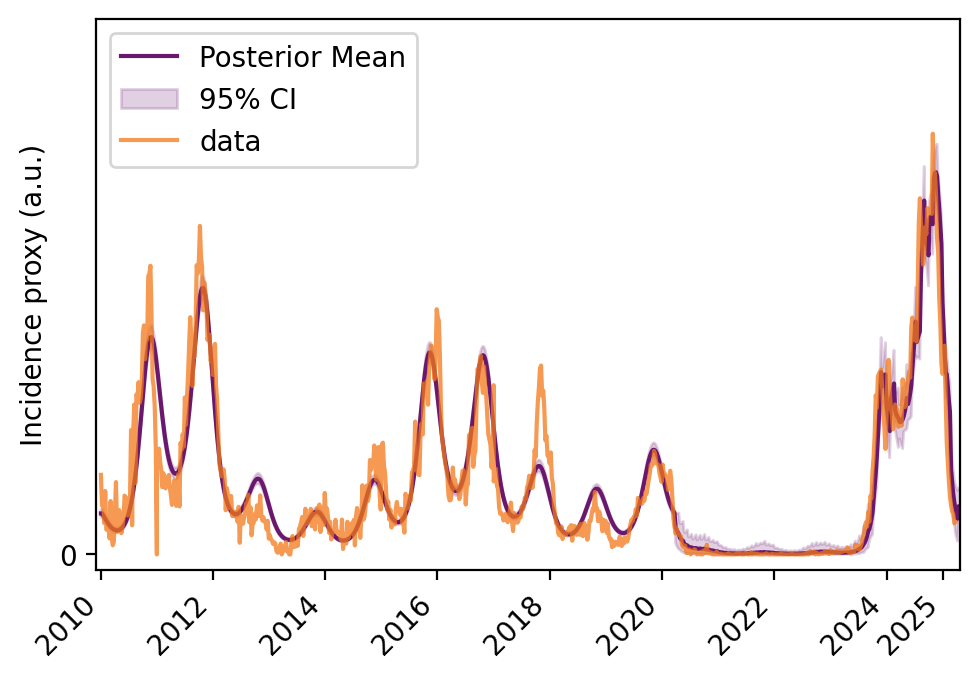

In [25]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

start_date = df["date"].iloc[0]
print(start_date)
n_time_points = v_draws.shape[1]
time_axis = pd.date_range(start=start_date, periods=n_time_points, freq="W-MON")

mean_v = np.mean(v_draws, axis=0)
lower_v = np.percentile(v_draws, 2.5, axis=0)
upper_v = np.percentile(v_draws, 97.5, axis=0)

plt.figure(figsize=(5, 3.5), dpi=200)
plt.plot(time_axis, mean_v, label='Posterior Mean', color=plt.cm.inferno(0.3))
plt.fill_between(time_axis, lower_v, upper_v, color=plt.cm.inferno(0.3), alpha=0.2, label='95% CI')

# Plot data
plt.plot(df["date"], df["value"], "-", label="data", color=plt.cm.inferno(0.7), alpha=0.75)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=24))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


my_xticks = []

curr_date = pd.to_datetime("2010.1.5")
my_xticks.append(curr_date)

curr_date_int = 2012
curr_date = pd.to_datetime(str(curr_date_int) + ".1") 
while curr_date < time_axis[-1]:
    my_xticks.append(curr_date)
    curr_date_int += 2
    curr_date = pd.to_datetime(str(curr_date_int))

curr_date = pd.to_datetime("2025.1.1")
my_xticks.append(curr_date)

print(my_xticks)

plt.xticks(my_xticks)
plt.yticks([0])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

#plt.xlabel("Time")
plt.ylabel("Incidence proxy (a.u.)")

plt.legend()
plt.tight_layout()
plt.xlim([start_date - pd.to_timedelta(30, unit='D'), df["date"].iloc[-1] + pd.to_timedelta(30, unit='D') ])

plt.ylim([-0.01, 0.35])

plt.show()


1317


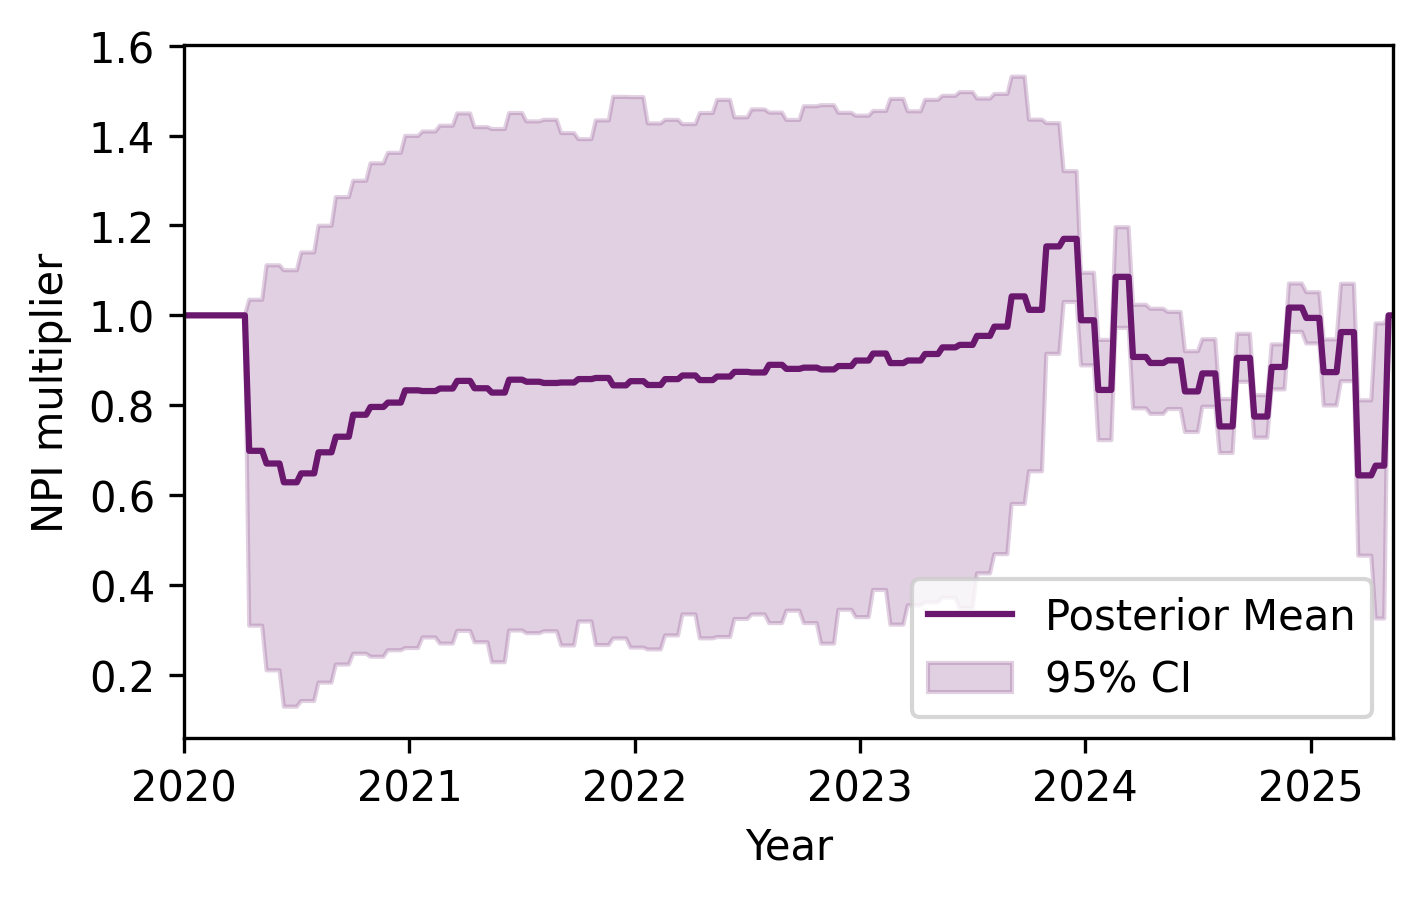

In [26]:
var = "npieff"

v_draws = fit.stan_variable(var)
print(v_draws.shape[1])

plt.figure(figsize=(5.2, 3), dpi=300)

############

mean_v = np.mean(v_draws, axis=0)  # average over draws
lower_v = np.percentile(v_draws, 2.5, axis=0)  # 2.5% quantile
upper_v = np.percentile(v_draws, 97.5, axis=0) # 97.5% quantile

time_fit = np.arange(1, v_draws.shape[1] + 1)/52 + 2010
time_data = np.arange(1, len(df['value']) + 1)/52 + 2010

plt.plot(time_fit, mean_v, label='Posterior Mean', color=plt.cm.inferno(0.3))


plt.fill_between(time_fit, lower_v, upper_v, color=plt.cm.inferno(0.3), alpha=0.2, label='95% CI')

plt.xlabel('Year')
plt.ylabel('NPI multiplier')
plt.legend()

plt.xlim([2020, 2025+4.4/12])

plt.show()


# Per-chain time-series:

In [27]:
import numpy as np
import matplotlib.pyplot as plt

#var = "I"
var = "Ifit"
#var = "beta"
#var = "npi"

S_draws_all = fit.stan_variable(var)

num_chains = fit.chains

draws_per_chain = S_draws_all.shape[0] // num_chains

S_draws_per_chain = S_draws_all.reshape(
    (num_chains, draws_per_chain, S_draws_all.shape[1])
)


Max of chain 1: 0.24967799500000004
Max of chain 2: 0.25001396666666664
Max of chain 3: 0.24932354166666665
Max of chain 4: 0.25034813499999997


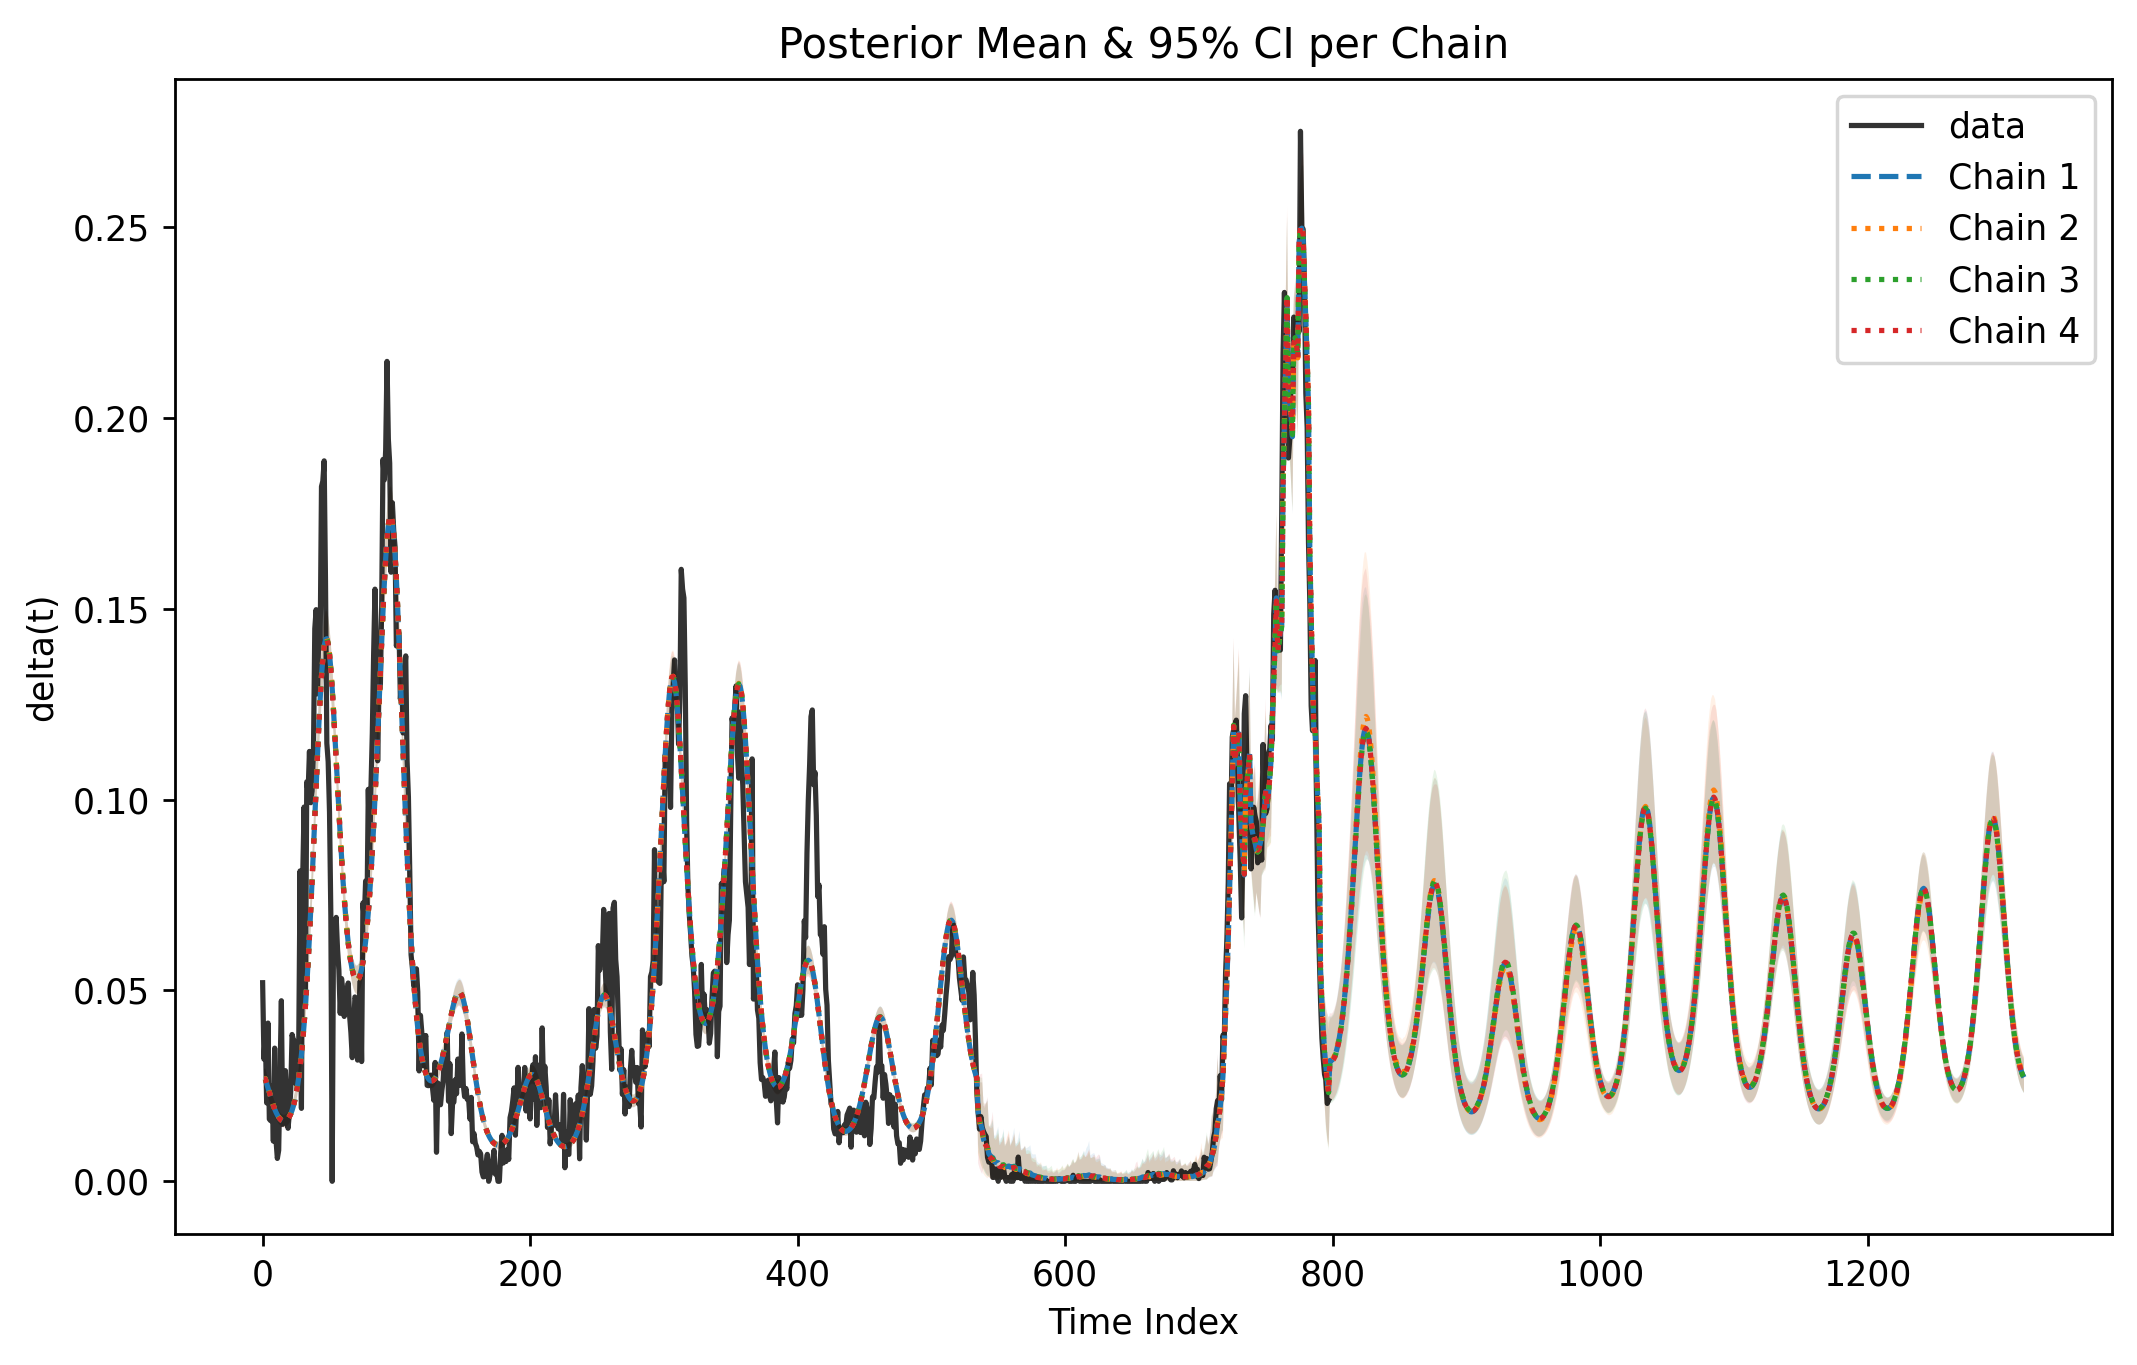

In [34]:
time_idx = np.arange(1, S_draws_per_chain.shape[2] + 1)

plt.figure(figsize=(10, 6), dpi=250)

plot_data = True

excluded_chains = []
#excluded_chains = [1,3,2]


if plot_data:
    plt.plot(df['value'], label="data", color='black', alpha=0.8)

for c in range(num_chains):
    if not (c+1 in excluded_chains):
        chain_data = S_draws_per_chain[c, :, :]  # shape: (draws_per_chain, time_points)
        chain_mean = chain_data.mean(axis=0)
        chain_lower = np.percentile(chain_data, 2.5, axis=0)
        chain_upper = np.percentile(chain_data, 97.5, axis=0)
        print(f"Max of chain {c+1}: {np.max(chain_mean)}")
    
        if c+1 < num_chains/2:
            plt.plot(time_idx, chain_mean, "--", label=f'Chain {c+1}')
        else:
            plt.plot(time_idx, chain_mean, ":", label=f'Chain {c+1}')
        plt.fill_between(time_idx, chain_lower, chain_upper, alpha=0.1)

plt.xlabel("Time Index")
plt.ylabel(f"{var}(t)")
plt.title("Posterior Mean & 95% CI per Chain")
plt.legend()

In [29]:
chain_of_interest = 1
df_draws = fit.draws_pd()

for var in ['S0', 'logx_I0', 'beta0', 'dbeta', 'betaphase', 'sigma_obs', 'logrho', 'delta']:
    c = chain_of_interest-1
    chain_subset = df_draws.iloc[c*draws_per_chain:(c+1)*draws_per_chain]
    mm = np.mean(chain_subset[var].values)
    sd = np.std(chain_subset[var].values)
    print(f"{var}: {mm}")
    if var == "logx_I0":
        print(f"\t(I0 = {10**mm * np.mean(chain_subset["S0"].values)})")
    if var=='delta':
        print(f"1/(mean({var})) = {1/mm:.3f} weeks = {(1/52)*1/mm:.3f} years")
        print(f"+ standard deviation: 1/(mean({var})) = {1/(mm+sd):.3f} weeks = {(1/52)*1/(mm+sd):.3f} years")
        print(f"- standard deviation: 1/(mean({var})) = {1/(mm-sd):.3f} weeks = {(1/52)*1/(mm-sd):.3f} years")

S0: 0.5712915416666666
logx_I0: -2.5916087666666665
	(I0 = 0.0014630158373078598)
beta0: 0.7136627366666667
dbeta: 0.18548208666666668
betaphase: 3.5957880999999996
sigma_obs: 0.01624441
logrho: -1.7147123666666664
delta: 0.0017279447500000004
1/(mean(delta)) = 578.722 weeks = 11.129 years
+ standard deviation: 1/(mean(delta)) = 527.485 weeks = 10.144 years
- standard deviation: 1/(mean(delta)) = 640.984 weeks = 12.327 years


# Pairwise posterior plots

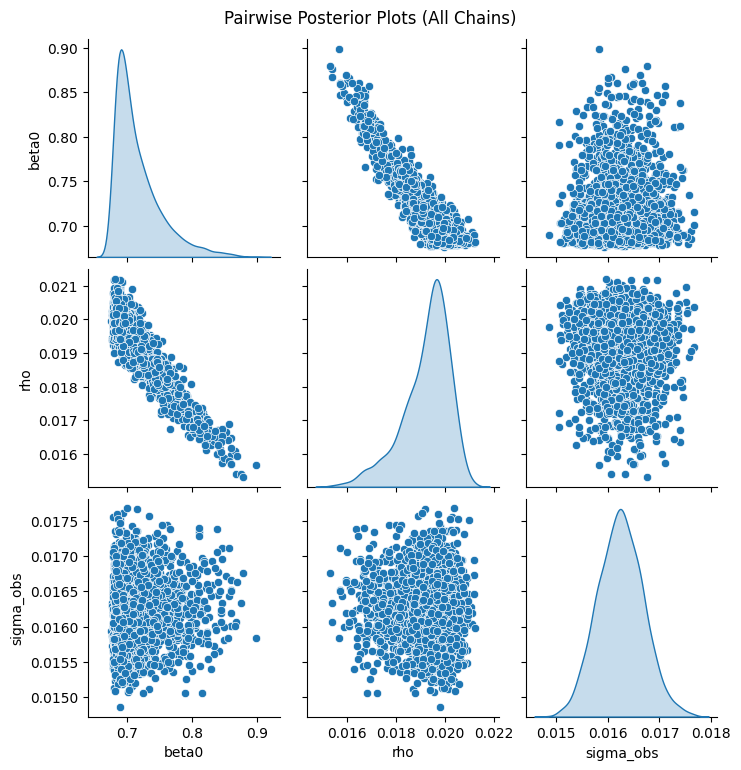

In [30]:
df_draws = fit.draws_pd()

params_of_interest = ["beta0", "rho", "sigma_obs"] 

df_subset = df_draws[params_of_interest]

sns.pairplot(df_subset, diag_kind="kde")
plt.suptitle("Pairwise Posterior Plots (All Chains)", y=1.02)
plt.show()


In [31]:
# Per-chain

In chain 1, averages were: sigma_obs : 0.01624441,   rho : 0.019309514166666666  (mean product: 0.00031365263074713333)


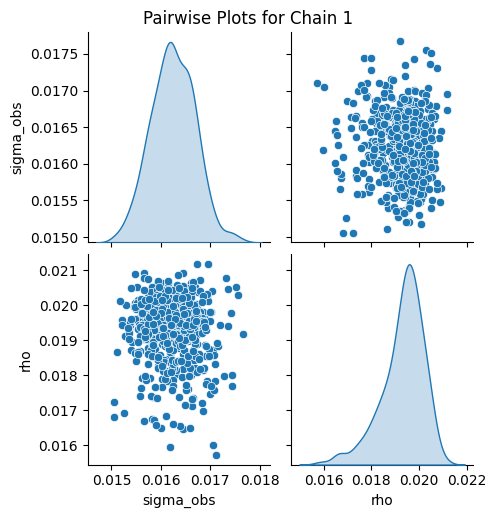

In chain 2, averages were: sigma_obs : 0.016247762,   rho : 0.019075772833333334  (mean product: 0.0003099231599756667)


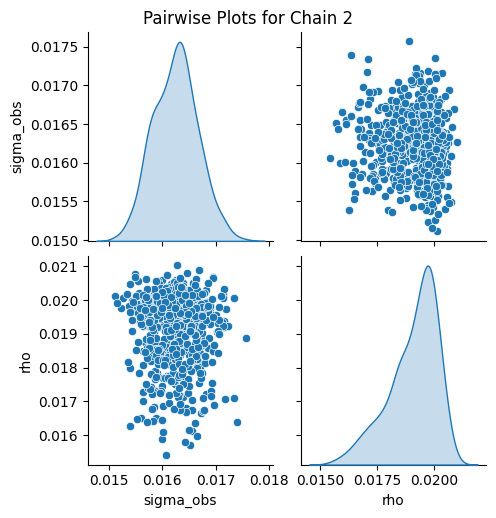

In chain 3, averages were: sigma_obs : 0.01627308283333333,   rho : 0.019287728  (mean product: 0.0003138494941452667)


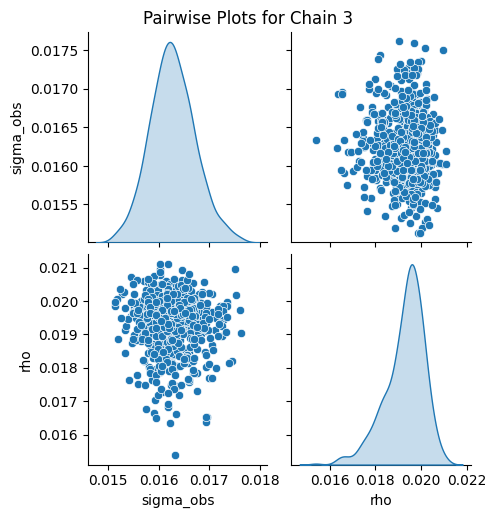

In chain 4, averages were: sigma_obs : 0.016228796333333333,   rho : 0.019233352166666665  (mean product: 0.00031211432790561667)


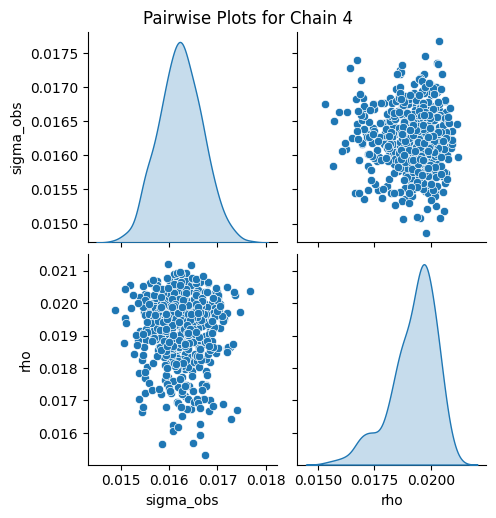

In [32]:
params_of_interest = ["sigma_obs", "rho"]
#params_of_interest = ["S0", "I0"]
#params_of_interest = ["betaphase", "delta"]
#params_of_interest = ["beta0", "rho"]

for c in range(num_chains):
    chain_subset = df_draws.iloc[c*draws_per_chain:(c+1)*draws_per_chain]
    # chain_subset now holds rows for chain c
    p1 = params_of_interest[0]
    p2 = params_of_interest[1]
    mp = np.mean(chain_subset[params_of_interest[0]].values*chain_subset[params_of_interest[1]].values)
    print(f"In chain {c+1}, averages were: {params_of_interest[0]} : {chain_subset[params_of_interest[0]].mean()},   {params_of_interest[1]} : {chain_subset[params_of_interest[1]].mean()}  (mean product: {mp})")
    for p in [p1, p2]:
        if p in ["delta"]:
            print(f"1/{p} = {1/np.mean(chain_subset[p].values)}")
    sns.pairplot(chain_subset[params_of_interest], diag_kind="kde")
    plt.suptitle(f"Pairwise Plots for Chain {c+1}", y=1.02)
    plt.show()
